In [275]:
import os
import random
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from utils import call_backs, misc, preprocessing
from custom_layers.arcface_loss import ArcMarginProduct

# to access cifar100
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Config

In [317]:
class config:
    # GENERAL
    RANDOM_SEED = 5
    TENSOR_LOG_DIR = 'logs'
    SAVE_DIR = 'saved_models'

    # DATA
    INPUT_SIZE = (32,32,3)
    NUM_CLASSES = 100 # holding out 5 classes from cifar100

    # MODEL
    OUTPUT_EMB = 64
    MIDDLE_EMB = 256

    # TRAINING
    EPOCHS = 5#30
    BATCH_SIZE = 32
    LR = .0005

misc.seed_everything(config.RANDOM_SEED)

### Load dataset

In [318]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

# images are of correct input_size
print('x_train shape:', x_train.get_shape())
assert x_train.get_shape()[-3:] == config.INPUT_SIZE

print('y_train shape:', y_train.get_shape())
# y_train has only 1 label per item in tensor
assert y_train.get_shape()[-1:] == 1

# num images == num labels
assert y_train.get_shape()[0] == x_train.get_shape()[0]



x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


In [319]:
class_count = Counter(np.array(tf.reshape(y_train, [y_train.get_shape()[0],])))
print(class_count)

Counter({19: 500, 29: 500, 0: 500, 11: 500, 1: 500, 86: 500, 90: 500, 28: 500, 23: 500, 31: 500, 39: 500, 96: 500, 82: 500, 17: 500, 71: 500, 8: 500, 97: 500, 80: 500, 74: 500, 59: 500, 70: 500, 87: 500, 84: 500, 64: 500, 52: 500, 42: 500, 47: 500, 65: 500, 21: 500, 22: 500, 81: 500, 24: 500, 78: 500, 45: 500, 49: 500, 56: 500, 76: 500, 89: 500, 73: 500, 14: 500, 9: 500, 6: 500, 20: 500, 98: 500, 36: 500, 55: 500, 72: 500, 43: 500, 51: 500, 35: 500, 83: 500, 33: 500, 27: 500, 53: 500, 92: 500, 50: 500, 15: 500, 18: 500, 46: 500, 75: 500, 38: 500, 66: 500, 77: 500, 69: 500, 95: 500, 99: 500, 93: 500, 4: 500, 61: 500, 94: 500, 68: 500, 34: 500, 32: 500, 88: 500, 67: 500, 30: 500, 62: 500, 63: 500, 40: 500, 26: 500, 48: 500, 79: 500, 85: 500, 54: 500, 44: 500, 7: 500, 12: 500, 2: 500, 41: 500, 37: 500, 13: 500, 25: 500, 10: 500, 57: 500, 5: 500, 60: 500, 91: 500, 3: 500, 58: 500, 16: 500})


In [320]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocessing.normalize).map(preprocessing.arcface_format).batch(config.BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocessing.normalize).map(preprocessing.arcface_format).batch(config.BATCH_SIZE)

### Define model 

In [321]:
# from custom_layers.arcface_loss import ArcMarginProduct
from custom_layers.subcenter_arcface_loss import SubcenterArcMarginProduct as ArcMarginProduct
# allows 2 inputs and 2 outputs

def get_debug_model(s = 10, m = .25, k = 3):
 #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = config.INPUT_SIZE, name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    
    #TODO: reasearch filters, get better understanding
    layer_conv1 = tf.keras.layers.Conv2D(filters = 24, kernel_size = (2,2), input_shape = config.INPUT_SIZE, activation ='relu')
    layer_pool1 = tf.keras.layers.MaxPool2D((2,2))
    layer_conv2 = tf.keras.layers.Conv2D(filters = 12, kernel_size = (2,2), activation ='relu')
    layer_pool2 = tf.keras.layers.MaxPool2D((2,2))
    layer_flatten = tf.keras.layers.Flatten()
    layer_dense1 = tf.keras.layers.Dense(config.MIDDLE_EMB)
    layer_dense2 = tf.keras.layers.Dense(config.NUM_CLASSES)
    layer_arcface = ArcMarginProduct(n_classes=config.NUM_CLASSES, s=s, m=m, k=k)
    layer_softmax = tf.keras.layers.Softmax(dtype='float16', name='head_output')

    if config.MIDDLE_EMB != config.OUTPUT_EMB:
        layer_adaptive_pooling = tfa.layers.AdaptiveAveragePooling1D(config.OUTPUT_EMB)
    else:
        layer_adaptive_pooling = tf.keras.layers.Lambda(lambda x: x)  # layer with no operation

    #------------------
    # Definition of entire model
    backbone_output = layer_conv1(inp)
    backbone_output = layer_pool1(backbone_output)
    backbone_output = layer_conv2(backbone_output)
    backbone_output = layer_pool2(backbone_output)
    embed = layer_flatten(backbone_output)
    embed = layer_dense1(embed)
    
    # Training head
    # head_output = layer_dense2(embed)
    head_output = layer_arcface((embed,label))
    head_output = layer_softmax(head_output)
    
    # Inference
    emb_output = layer_adaptive_pooling(embed)

    model = tf.keras.models.Model(inputs = [(inp, label)], outputs = [head_output, emb_output]) # whole architecture

    return model

In [350]:
debug_model = get_debug_model(s=32, m=.15, k=2)
debug_model.summary()

(100, None)
Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_46 (Conv2D)             (None, 31, 31, 24)   312         ['inp1[0][0]']                   
                                                                                                  
 max_pooling2d_46 (MaxPooling2D  (None, 15, 15, 24)  0           ['conv2d_46[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 14, 14, 12)   1164        ['max_pooling2

In [351]:
debug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = config.LR),
        loss = {'head_output':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)},
        metrics = {'head_output':[tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)]},
        )

steps_per_epoch = len(train_dataset) // config.BATCH_SIZE  // 20     # "//20" means that the lr is update every 0.1 epoch.
validation_steps = len(test_dataset) // config.BATCH_SIZE
if len(test_dataset) % config.BATCH_SIZE != 0:
    validation_steps += 1
print(steps_per_epoch, validation_steps)

2 10


### Callbacks

In [352]:
# tensorboard

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                        #  write_graph=True,
                        #  write_images=True,
                        update_freq='epoch',
                        #  profile_batch=2,
                        #  embeddings_freq=1
                        )

#emb_callback = call_backs.EmbeddingCallback(x_test, y_test, save_dir = log_dir+'/emb/', embedding_dim = config.OUTPUT_EMB)

### Training

In [353]:
history = debug_model.fit(
        train_dataset,
        epochs=config.EPOCHS,
        validation_steps = validation_steps,
        validation_data = test_dataset,
        verbose=1,
        #callbacks=[tensorboard_callback]
    )

Epoch 1/5
(100, None)
(100, None)
1563/1563 [==============================] - 30s 19ms/step - loss: 8.2992 - head_output_loss: 8.2992 - head_output_sparse_categorical_accuracy: 0.0000e+00 - head_output_sparse_top_k_categorical_accuracy: 1.0000e-04 - val_loss: 7.9707 - val_head_output_loss: 7.9707 - val_head_output_sparse_categorical_accuracy: 0.0000e+00 - val_head_output_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/5
1563/1563 [==============================] - 35s 23ms/step - loss: 7.9043 - head_output_loss: 7.9043 - head_output_sparse_categorical_accuracy: 2.0000e-05 - head_output_sparse_top_k_categorical_accuracy: 6.2000e-04 - val_loss: 7.8355 - val_head_output_loss: 7.8355 - val_head_output_sparse_categorical_accuracy: 0.0000e+00 - val_head_output_sparse_top_k_categorical_accuracy: 0.0031
Epoch 3/5
1563/1563 [==============================] - 43s 28ms/step - loss: 7.7947 - head_output_loss: 7.7947 - head_output_sparse_categorical_accuracy: 3.2000e-04 - head_output_sparse_

In [354]:
print("Test examples:",len(x_test))
pred_class, pred_emb = debug_model.predict((x_test, y_test))  # I don't like this, (hacky way would be y test of -1s if non given)

# argmax returns largest element's index
pred_class = tf.argmax(pred_class, axis=1)
true_class = y_test

Test examples: 10000
(100, None)
313/313 [==============================] - 4s 11ms/step


KeyboardInterrupt: 

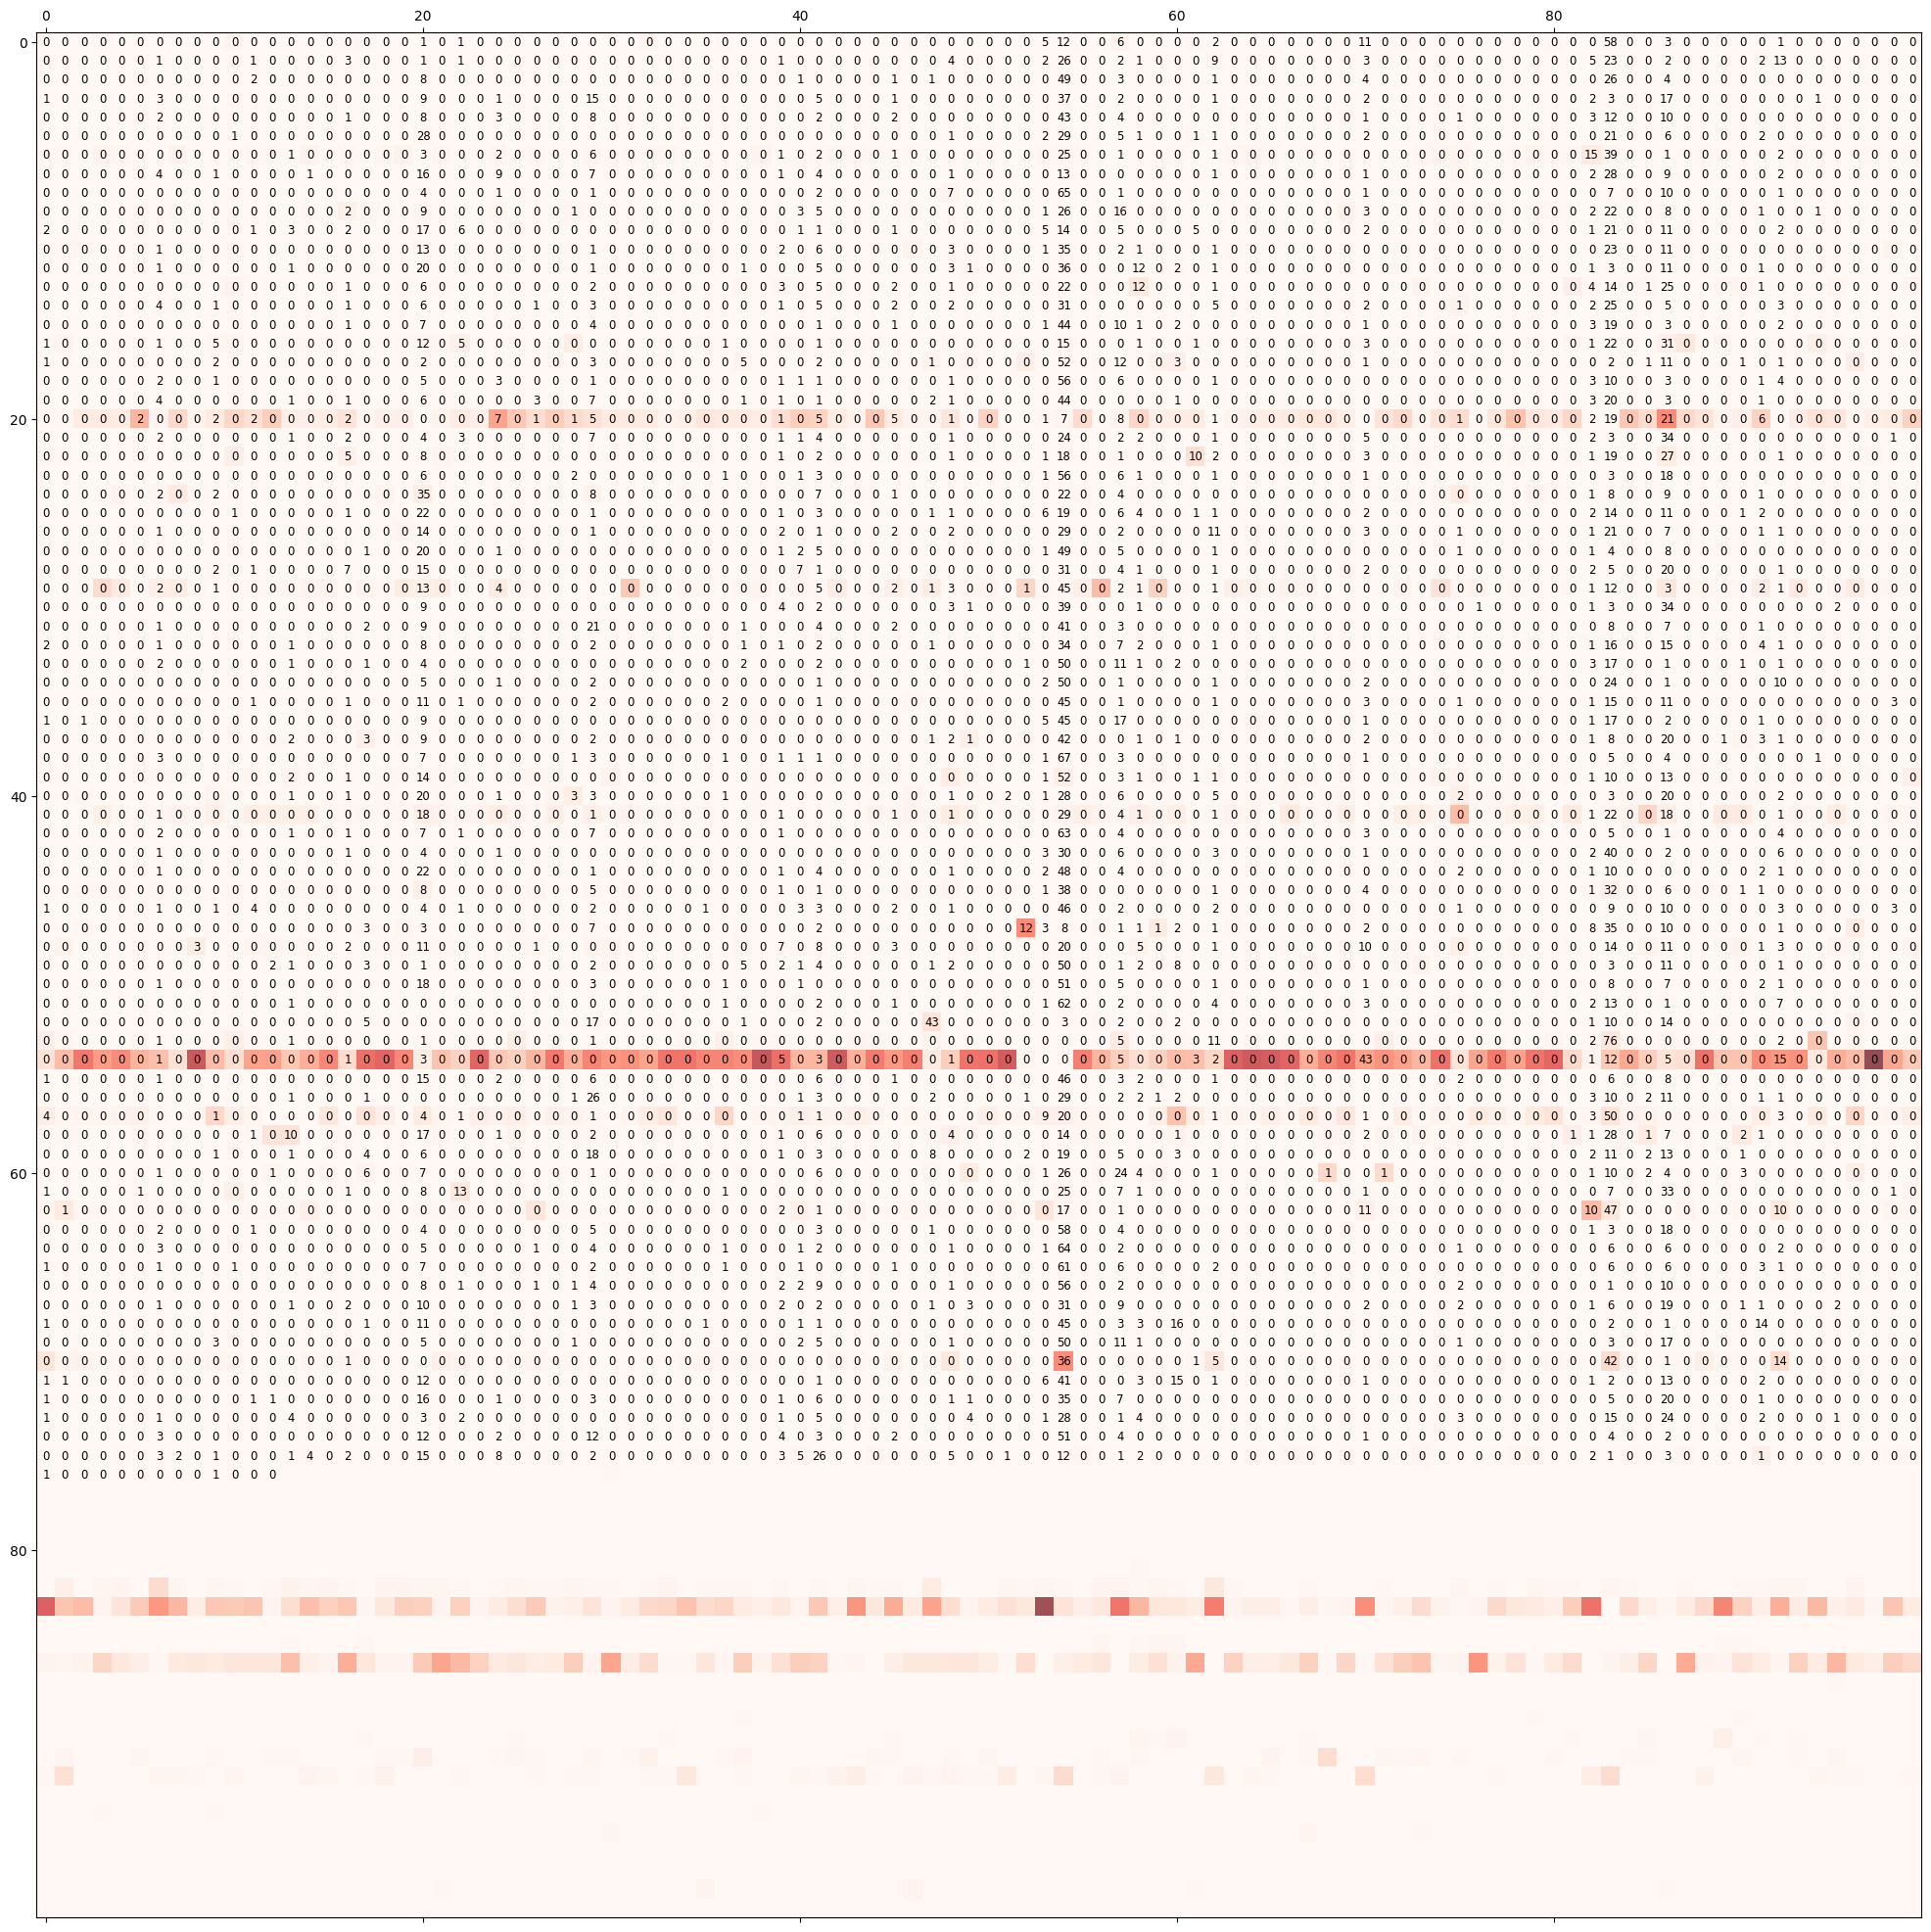

In [356]:
# import matplotlib.pyplot as plt
# cm_df = pd.DataFrame(confusion_matrix)

# fig, ax = plt.subplots(figsize=(25,25))
# ax.matshow(cm_df, cmap=plt.cm.Reds, alpha=0.7)
# for i in range(cm_df.shape[0]):
#     for j in range(cm_df.shape[1]):
#         ax.text(x=j, y=i,s=cm_df[i][j], va='center', ha='center', size='small')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()

In [357]:
emb_df = pd.DataFrame(embedding_data)
emb_df.head()

In [358]:
emb_df['length']=emb_df['embedding'].apply(dist_to_origin)
emb_df['normed_embeddings']=emb_df['embedding']/emb_df['length']

In [359]:
tree.build(20)

True

In [360]:


emb_df['nearest_neighbors'] = emb_df['annoy_idx'].apply(n_neighbors)
emb_df['neighbor_classes'] = emb_df.apply(lambda row: neighbor_classes(row,emb_df,true_classes=True), axis=1)
emb_df['neighbor_pred_classes'] = emb_df.apply(lambda row: neighbor_classes(row,emb_df,true_classes=False), axis=1)
emb_df['matching_neighbors'] = emb_df.apply(lambda row: matching_neighbors(row,true_classes=True), axis=1)
emb_df['matching_neighbor_preds'] = emb_df.apply(lambda row: matching_neighbors(row,true_classes=False), axis=1)

In [361]:
emb_df.head()

,annoy_idx,true_class,pred_class,embedding,length,normed_embeddings,nearest_neighbors,neighbor_classes,neighbor_pred_classes,matching_neighbors,matching_neighbor_preds
0,0,49,54,"[-0.3515277, 30.659218, -13.035518, -2.1481628...",135.579559,"[-0.0025927778, 0.22613451, -0.09614663, -0.01...","[9713, 8732, 5247, 9638, 2275]","[55, 30, 15, 30, 31]","[20, 20, 54, 20, 54]",0,2
1,1,33,54,"[-11.414749, 20.03775, 1.6777735, 2.020296, 8....",80.720467,"[-0.14141084, 0.2482363, 0.020784982, 0.025028...","[180, 2261, 2615, 1189, 7704]","[39, 38, 4, 55, 67]","[54, 54, 54, 29, 86]",0,3
2,2,72,83,"[-1.6940017, 19.254358, -15.596289, 2.1179142,...",123.503448,"[-0.01371623, 0.15590139, -0.12628222, 0.01714...","[51, 1697, 1991, 2147, 6109]","[6, 44, 98, 8, 4]","[83, 41, 20, 54, 83]",0,2
3,3,51,54,"[5.133849, 28.81355, -9.623365, 9.839807, -0.1...",136.210373,"[0.037690587, 0.21153712, -0.07065076, 0.07223...","[369, 5375, 3890, 1098, 8351]","[65, 84, 73, 51, 18]","[54, 54, 41, 54, 54]",1,4
4,4,71,70,"[1.4966631, 10.085162, -24.424803, -5.2149997,...",111.848427,"[0.013381173, 0.09016812, -0.21837413, -0.0466...","[1799, 6593, 5852, 6315, 4493]","[34, 65, 57, 71, 71]","[70, 62, 53, 53, 53]",2,1


In [363]:
competition_score(emb_df,5)

0.11642

In [313]:
emb_df['correct_prediction'] = emb_df['true_class']==emb_df['pred_class']

In [314]:
print(emb_df['correct_prediction'].value_counts())

False    9233
True      767
Name: correct_prediction, dtype: int64


In [315]:
emb_df['matching_neighbor_preds'].value_counts()

1    1866
2    1760
0    1707
3    1706
4    1605
5    1356
Name: matching_neighbor_preds, dtype: int64

In [316]:
emb_df['matching_neighbors'].value_counts()

0    6864
1    1946
2     670
3     309
4     152
5      59
Name: matching_neighbors, dtype: int64